      time    total  gasoline   diesel  fgas  ngas  electricity  petroleum  \
0  2018-01  2930483   1781826  1136656    12   256         9304          0   
1  2018-02  2934044   1783338  1138414    12   255         9343          0   
2  2018-03  2941422   1787219  1141576    12   257         9399          0   
3  2018-04  2951498   1793554  1144846    12   257         9548          0   
4  2018-05  2963093   1799795  1149840    12   256         9665          0   

   hydrogen  methanol  ethanol  pluginhybrid  otherfuels  
0        81         0        0          2340           8  
1        80         0        0          2593           9  
2        77         0        0          2873           9  
3        77         0        0          3195           9  
4        77         0        0          3439           9  


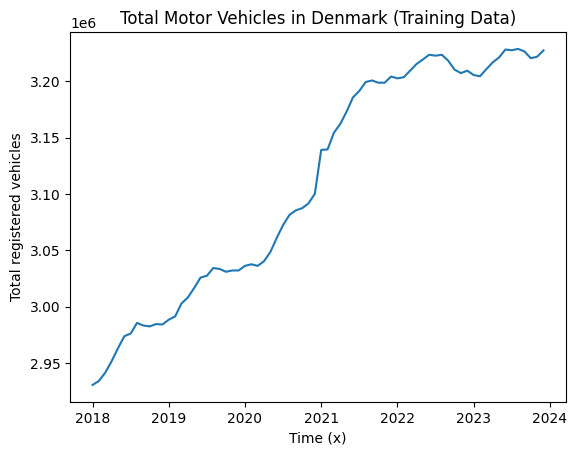

Theta1_hat: -110355428.09604625
Theta2_hat: 56144.556226548615


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
file_path = "DST_BIL54.csv"
df = pd.read_csv(file_path)

# ---- Inspect column names (uncomment if needed) ----
print(df.head())

# Assume there is a column called 'time' formatted like '2018M01'
# and a column called 'total'

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

# Sort just to be safe
df = df.sort_values('time')

# Create training set (up to 2023-Dec)
train = df[df['time'] <= '2023-12-31'].copy()

# Create time variable x
# x = year + (month-1)/12
train['x'] = train['time'].dt.year + (train['time'].dt.month - 1) / 12

# Extract variable of interest
y = train['total']

# Plot
plt.figure()
plt.plot(train['x'], y)
plt.xlabel('Time (x)')
plt.ylabel('Total registered vehicles')
plt.title('Total Motor Vehicles in Denmark (Training Data)')
plt.show()

# Construct design matrix
X = np.column_stack((np.ones(len(train)), train['x']))

# OLS estimation
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

theta1_hat = beta_hat[0]
theta2_hat = beta_hat[1]

print("Theta1_hat:", theta1_hat)
print("Theta2_hat:", theta2_hat)


In [14]:
# Fitted values
y_hat = X @ beta_hat

# Residuals
residuals = y - y_hat
p=len(beta_hat)

n = len(train)
sigma2_hat = (residuals @ residuals) / (n - p)

# Variance-covariance matrix
var_beta_hat = sigma2_hat * np.linalg.inv(X.T @ X)

se_theta1 = np.sqrt(var_beta_hat[0,0])
se_theta2 = np.sqrt(var_beta_hat[1,1])

print("SE Theta1:", se_theta1)
print("SE Theta2:", se_theta2)


SE Theta1: 3593581.121593794
SE Theta2: 1778.1563047539312


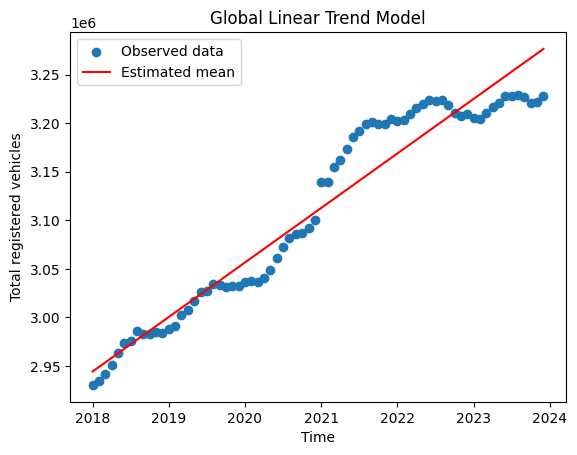

In [15]:
plt.figure()

# Observations as points
plt.scatter(train['x'], y, label="Observed data")

# Estimated mean (fitted line)
plt.plot(train['x'], y_hat, color='red', label="Estimated mean")

plt.xlabel("Time")
plt.ylabel("Total registered vehicles")
plt.title("Global Linear Trend Model")
plt.legend()

plt.show()


In [16]:
from scipy.stats import t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Future dates: Jan 2024 to Dec 2024
future_dates = pd.date_range(start="2024-01-01", end="2024-12-01", freq="MS")
future_x = future_dates.year + (future_dates.month - 1)/12

# Design matrix for forecast
X_future = np.column_stack((np.ones(len(future_x)), future_x))

# Forecasted values
y_forecast = X_future @ beta_hat

# Prediction intervals
T = len(train)
alpha = 0.05
t_crit = t.ppf(1-alpha/2, df=T-p)

pred_var = []
X_inv = np.linalg.inv(X.T @ X)
for i in range(len(future_x)):
    x_vec = X_future[i]
    var = sigma2_hat * (1 + x_vec @ X_inv @ x_vec.T)
    pred_var.append(var)
pred_se = np.sqrt(pred_var)

lower = y_forecast - t_crit * pred_se
upper = y_forecast + t_crit * pred_se

# Forecast table
forecast_df = pd.DataFrame({
    "Month": future_dates.strftime('%Y-%m'),
    "Forecast": y_forecast,
    "Lower_PI": lower,
    "Upper_PI": upper
})
print(forecast_df)


      Month      Forecast      Lower_PI      Upper_PI
0   2024-01  3.281154e+06  3.227579e+06  3.334728e+06
1   2024-02  3.285832e+06  3.232198e+06  3.339467e+06
2   2024-03  3.290511e+06  3.236815e+06  3.344208e+06
3   2024-04  3.295190e+06  3.241430e+06  3.348950e+06
4   2024-05  3.299869e+06  3.246044e+06  3.353693e+06
5   2024-06  3.304547e+06  3.250656e+06  3.358439e+06
6   2024-07  3.309226e+06  3.255267e+06  3.363185e+06
7   2024-08  3.313905e+06  3.259876e+06  3.367934e+06
8   2024-09  3.318583e+06  3.264483e+06  3.372683e+06
9   2024-10  3.323262e+06  3.269090e+06  3.377435e+06
10  2024-11  3.327941e+06  3.273694e+06  3.382188e+06
11  2024-12  3.332620e+06  3.278297e+06  3.386942e+06


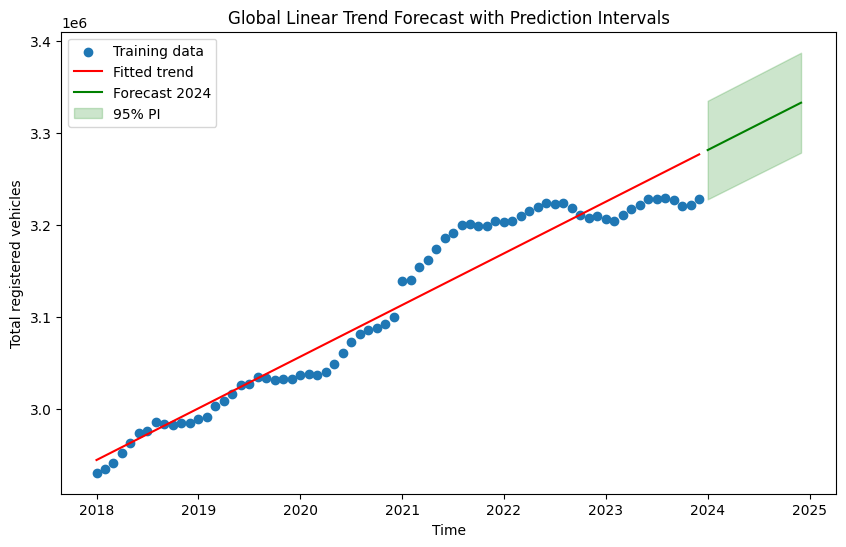

In [17]:
plt.figure(figsize=(10,6))

# Training data
plt.scatter(train['x'], y, label="Training data")

# Fitted model
plt.plot(train['x'], y_hat, color='red', label="Fitted trend")

# Forecast
plt.plot(future_x, y_forecast, color='green', label="Forecast 2024")

# Prediction intervals
plt.fill_between(future_x, lower, upper, color='green', alpha=0.2, label="95% PI")

plt.xlabel("Time")
plt.ylabel("Total registered vehicles")
plt.title("Global Linear Trend Forecast with Prediction Intervals")
plt.legend()
plt.show()


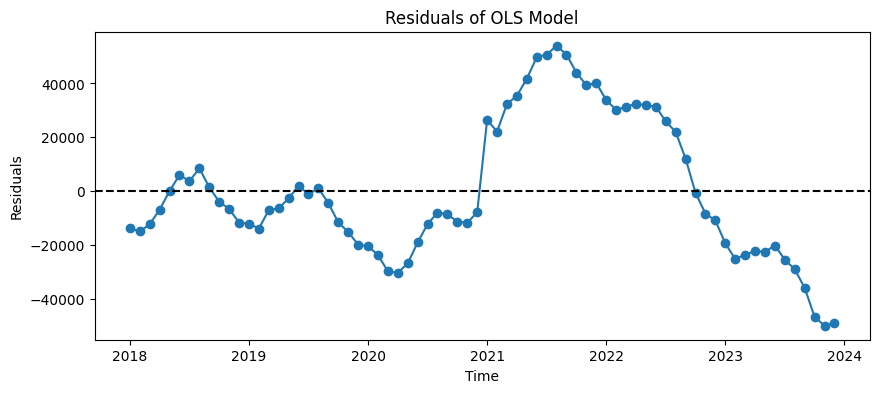

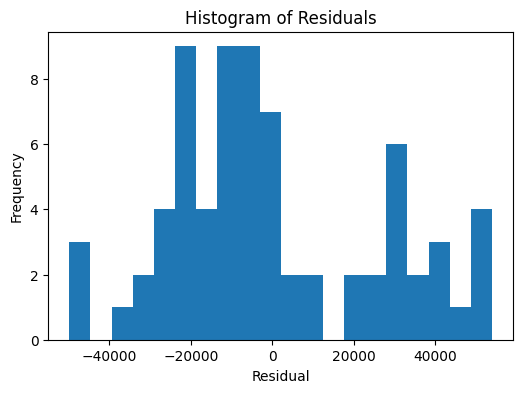

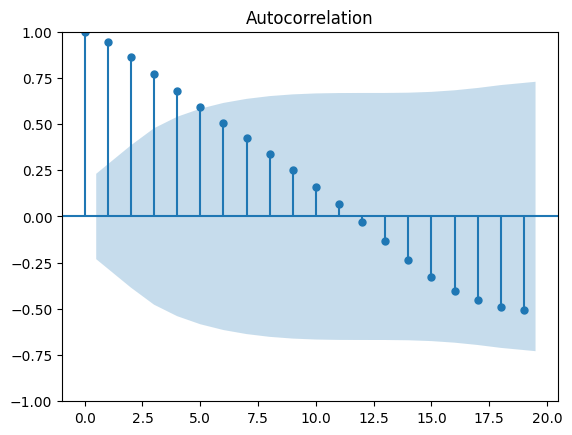

In [18]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Residual plot
plt.figure(figsize=(10,4))
plt.plot(train['x'], residuals, marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Residuals of OLS Model")
plt.show()

# Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# Autocorrelation plot
plot_acf(residuals)
plt.show()


In [36]:
import numpy as np

lam = 0.9
N = len(train)

# Most recent observation gets weight 1
weights = lam ** np.arange((N-1), -1, -1)

# Diagonal weight matrix
W = np.diag(weights)


In [37]:
W

array([[5.63920873e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.26578748e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.96198609e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.10000000e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.00000000e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

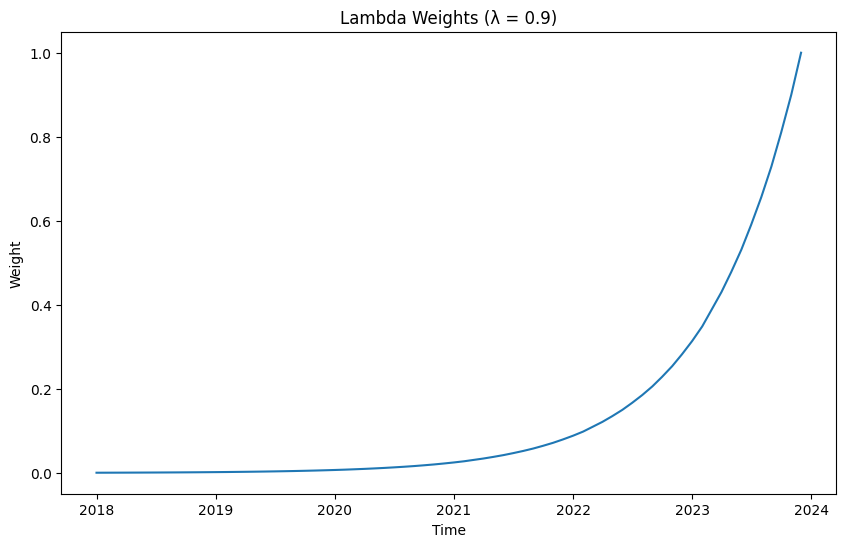

In [38]:
plt.figure(figsize=(10,6))
plt.plot(train['time'], weights)
plt.title("Lambda Weights (λ = 0.9)")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.show()

In [22]:
# WLS estimator
beta_wls = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)

theta1_wls = beta_wls[0]
theta2_wls = beta_wls[1]

print("WLS Theta1:", theta1_wls)
print("WLS Theta2:", theta2_wls)


WLS Theta1: -52482861.787286006
WLS Theta2: 27529.90156987076


In [23]:
import pandas as pd

# Create 12 future months
last_date = train['time'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Create x variable
x_future = future_dates.year + (future_dates.month - 1) / 12

# Design matrix for forecast
X_future = np.column_stack((np.ones(len(x_future)), x_future))

# WLS forecast
forecast_wls = X_future @ beta_wls


In [24]:
forecast_wls

array([3237658.99013241, 3239953.14859656, 3242247.30706073,
       3244541.46552487, 3246835.62398903, 3249129.78245319,
       3251423.94091734, 3253718.0993815 , 3256012.25784566,
       3258306.41630981, 3260600.57477397, 3262894.73323813])

In [25]:
# Fitted values
y_hat_wls = X @ beta_wls

# Residuals
res_wls = y - y_hat_wls

p = X.shape[1]
sigma2_wls = (res_wls.T @ W @ res_wls) / (N - p)

# Variance of beta
var_beta_wls = sigma2_wls * np.linalg.inv(X.T @ W @ X)


In [26]:
from scipy.stats import t

t_crit = t.ppf(0.975, df=N-p)

lower_pi = []
upper_pi = []

for x0 in X_future:
    var_pred = sigma2_wls * (1 + x0 @ np.linalg.inv(X.T @ W @ X) @ x0)
    se_pred = np.sqrt(var_pred)
    
    lower_pi.append((x0 @ beta_wls) - t_crit * se_pred)
    upper_pi.append((x0 @ beta_wls) + t_crit * se_pred)

lower_pi = np.array(lower_pi)
upper_pi = np.array(upper_pi)


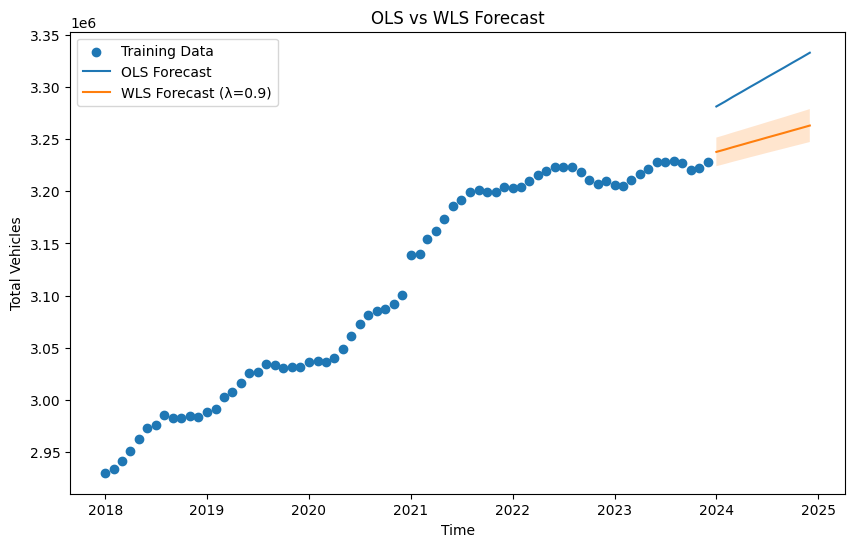

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Training data
plt.scatter(train['time'], y, label='Training Data')

# OLS forecast
plt.plot(future_dates, X_future @ beta_hat, label='OLS Forecast')

# WLS forecast
plt.plot(future_dates, forecast_wls, label='WLS Forecast (λ=0.9)')

# Prediction intervals (WLS)
plt.fill_between(future_dates, lower_pi, upper_pi, alpha=0.2)

plt.legend()
plt.title("OLS vs WLS Forecast")
plt.xlabel("Time")
plt.ylabel("Total Vehicles")
plt.show()


In [28]:
sum_weights = np.sum(weights)
print("Sum of λ-weights:", sum_weights)
print("Sum of OLS weights:", N)


Sum of λ-weights: 9.994924712139436
Sum of OLS weights: 72
